In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

warnings.filterwarnings('ignore')

C:\Users\Memphis Meng\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Memphis Meng\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Memphis Meng\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Memphis Meng\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
movies = pd.read_csv('movieLens/movies.csv')
movies = movies[['id', 'title', 'genres']]

In [3]:
all_genres = [s.split(", ") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)

In [4]:
for genre in unique_genres:
  movies[genre] = 0

for i in range(len(movies)):
  if pd.isnull(movies['genres'].iloc[i]) is False:
    Genres = movies.iloc[i].genres.split(', ')
    for g in Genres:
      movies[g].iloc[i] = 1

In [5]:
movies.tail()

,id,title,genres,romance,comedy,drama,war,documentary,thriller,music,...,mystery,foreign,fantasy,animation,action,family,adventure,history,science fiction,horror
46623,439050,Subdue,"drama, family",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46624,111109,Century of Birthing,drama,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46625,67758,Betrayal,"action, drama, thriller",0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
46626,227506,Satan Triumphant,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46627,461257,Queerama,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
dir = 'movieLens/data/'

In [7]:
def load_img_genres(datadir, df):
  image_path = []
  genres = []
  for i in range(len(movies)):
    indexed_data = movies.iloc[i]
    id = indexed_data[0]
    if os.path.exists(datadir + str(id) + '.jpg'):
        image_path.append(datadir + str(id) + '.jpg')
        genres.append(indexed_data[[_ for _ in range(3, 23)]])
  image_paths = np.asarray(image_path)
  genres = np.asarray(genres)
  return image_paths, genres

In [8]:
train_image_paths, train_genres = load_img_genres(dir + 'train/', movies)
test_image_paths, test_genres = load_img_genres(dir + 'test/', movies)

# augamentation

In [9]:
from imgaug import augmenters as iaa

def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [10]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [11]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-.1, .1), 'y': (-.1, .1)})
  image = pan.augment_image(image)
  return image

In [12]:
def random_augment(image):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
    image = zoom(image)
    image = img_random_brightness(image)
  return image

Text(0.5, 1, 'Augmented Image')

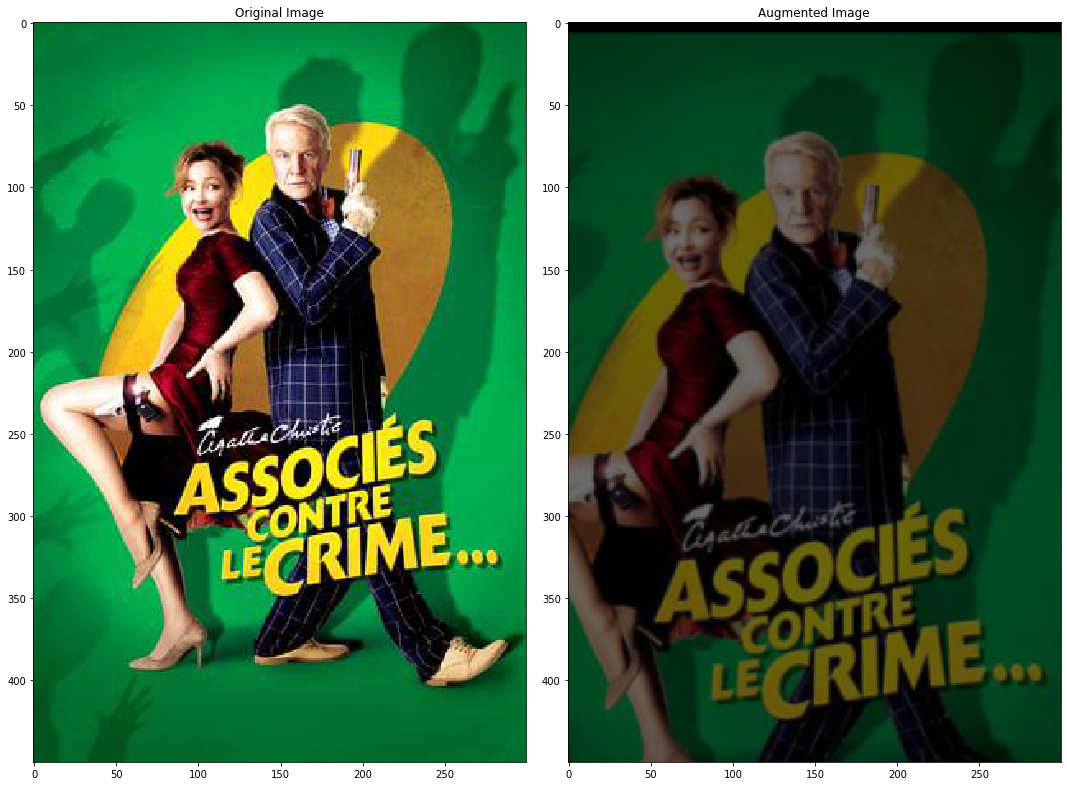

In [13]:
ncol = 2
nrow = 1
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
randomnum = random.randint(0, len(train_image_paths) - 1)
random_image = train_image_paths[randomnum]
original_image = mpimg.imread(random_image)
augmented_image = random_augment(random_image)

axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(augmented_image)
axes[1].set_title('Augmented Image')

# preprocessing

In [14]:
def img_preprocess(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  # cancel noises
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (300, 500))
  img = img/255
  return img

Text(0.5, 1, 'Preprocessed Image')

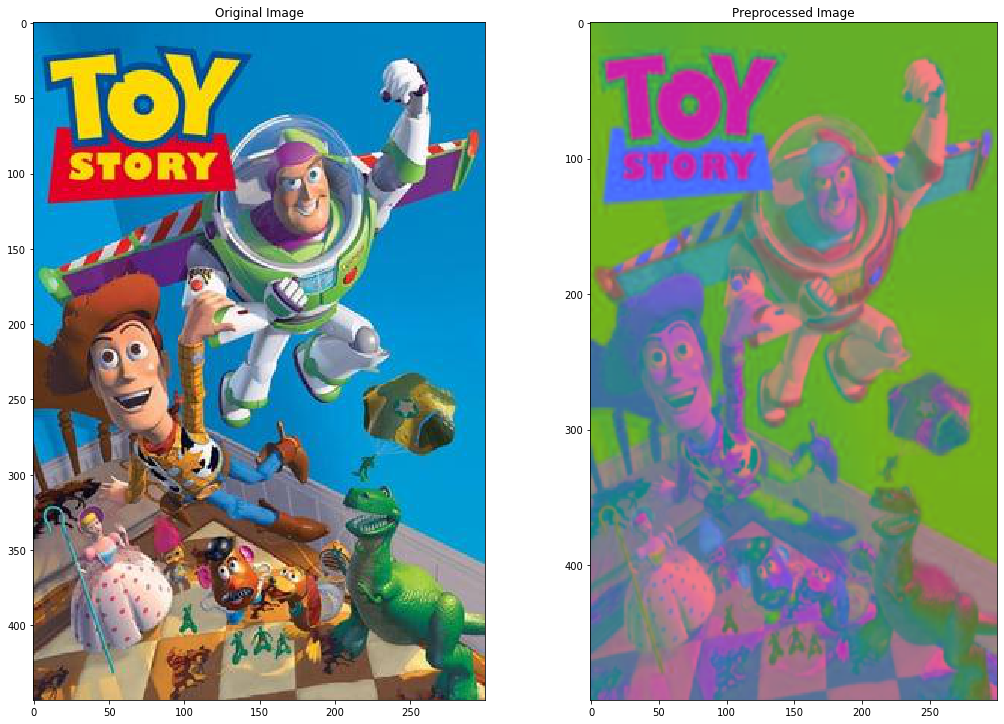

In [15]:
image = train_image_paths[0] # sample
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [16]:
def batch_generator(image_paths, steering_angle, batch_size, training):
  while True:
    batch_img = []
    batch_genres = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if training:
        im = random_augment(image_paths[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        
      genres = steering_angle[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_genres.append(genres)
    
    yield (np.asarray(batch_img), np.asarray(batch_genres))

Text(0.5, 1, 'Validation Image')

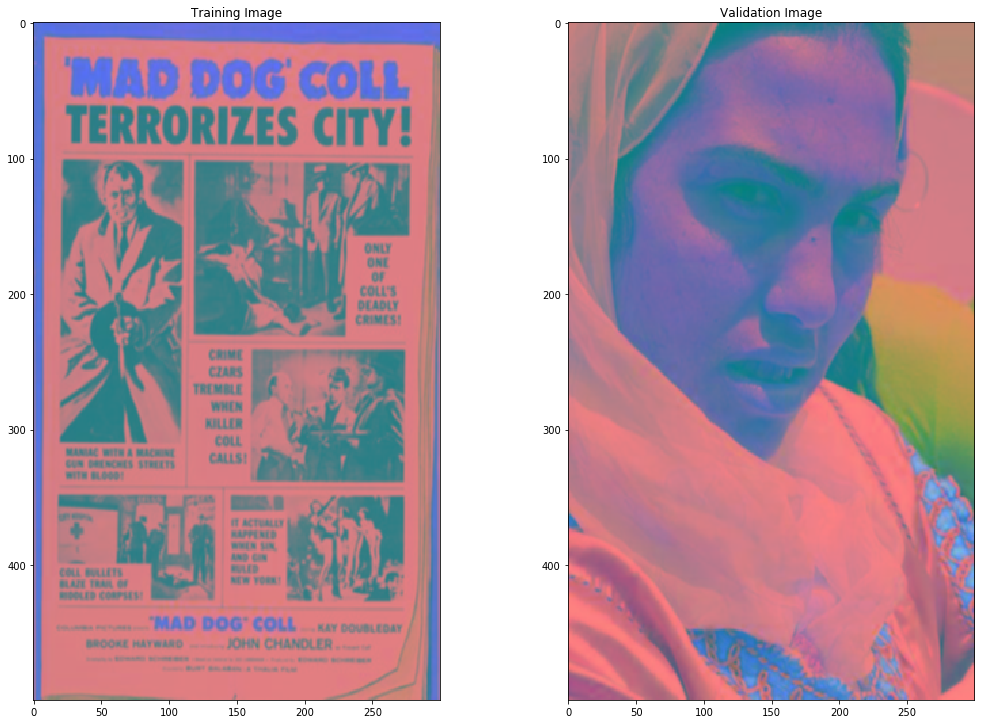

In [17]:
x_train_gen, y_train_gen = next(batch_generator(train_image_paths, train_genres, 50, True))
x_valid_gen, y_valid_gen = next(batch_generator(test_image_paths, test_genres, 50, False))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Image')

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [19]:
IMG_SHAPE = (500, 300, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
base_model.trainable = False
print(base_model.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 501, 301, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 250, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 250, 150, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 16, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
history = model.fit_generator(batch_generator(train_image_paths, train_genres, 100, True), 
      steps_per_epoch=300, 
      epochs=20, 
      validation_data=batch_generator(test_image_paths, test_genres, 100, False),
      validation_steps=200,
      verbose=1, 
      shuffle=1)

Epoch 1/20
  1/300 [..............................] - ETA: 8:27:48 - loss: 0.7119 - accuracy: 0.5655